In [720]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd 
from tkinter import filedialog

In [721]:
file = filedialog.askopenfilename(
    title="Select file",
    filetypes=[("All files", "*.*")]
)

In [722]:
df = pd.read_excel(file)

In [723]:
df['weekday'] = df['date'].dt.day_name()

In [724]:
df.drop(columns=['day' , 'client' , 'iphone'], inplace=True)

In [725]:
df

,date,calls,holiday,holiday-name,weekday
0,2025-01-01,268,1,New Year's Day,Wednesday
1,2025-01-02,1060,0,NaN,Thursday
2,2025-01-03,1043,0,NaN,Friday
3,2025-01-04,697,0,NaN,Saturday
4,2025-01-05,347,0,NaN,Sunday
...,...,...,...,...,...
322,2025-11-21,1377,0,NaN,Friday
323,2025-11-22,1105,0,NaN,Saturday
324,2025-11-23,792,0,NaN,Sunday
325,2025-11-24,1488,0,NaN,Monday


In [726]:
from sklearn.preprocessing import MinMaxScaler

In [727]:
df['weekday'] = df['date'].dt.weekday  # 0=Lunes, 6=Domingo

# Codificación cíclica
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)


In [728]:
# Baseline: solo llamadas + codificación cíclica de día
if 'calls' not in df.columns:
    raise ValueError("La columna 'calls' no existe en el dataframe cargado.")
features = df[['calls','weekday_sin','weekday_cos']].copy()
features.head()

,calls,weekday_sin,weekday_cos
0,268,0.974928,-0.222521
1,1060,0.433884,-0.900969
2,1043,-0.433884,-0.900969
3,697,-0.974928,-0.222521
4,347,-0.781831,0.623490


In [729]:
# Escala sólo la columna target 'calls'
scaler = MinMaxScaler()
features[['calls']] = scaler.fit_transform(features[['calls']])


In [730]:
def create_windows(data, window_size=45, forecast_horizon=30):
    """
    data: numpy array de shape (num_dias, num_features)
    return: X de shape (num_windows, window_size, num_features)
            y de shape (num_windows, forecast_horizon)
    """
    X = []
    y = []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])                                    # 60 días de entrada
        y.append(data[i+window_size:i+window_size+forecast_horizon, 0])    # 15 días de calls normalizadas
    return np.array(X), np.array(y)

data_array = features.values  # (num_dias, 3)
window_size = 45
forecast_horizon = 30

X, y = create_windows(data_array, window_size=window_size, forecast_horizon=forecast_horizon)
print("Shape X:", X.shape)  # (num_windows, 60, 3)
print("Shape y:", y.shape)  # (num_windows, 15)

Shape X: (253, 45, 3)
Shape y: (253, 30)


In [731]:
num_windows = X.shape[0]

train_size = int(num_windows * 0.8)
val_size   = int(num_windows * 0.1)
test_size  = num_windows - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val   = X[train_size:train_size+val_size]
y_val   = y[train_size:train_size+val_size]

X_test  = X[train_size+val_size:]
y_test  = y[train_size+val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (202, 45, 3) (202, 30)
Val:   (25, 45, 3) (25, 30)
Test:  (26, 45, 3) (26, 30)


In [732]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

num_features = X.shape[2]
forecast_horizon = y.shape[1]

model = tf.keras.Sequential([
    layers.Input(shape=(window_size, num_features)),
    layers.LSTM(128, activation='tanh', return_sequences=True),
    layers.LSTM(64, activation='tanh'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(forecast_horizon)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_96 (LSTM)                  │ (None, 45, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_97 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,518 (529.37 KB)

 Trainable params: 135,518 (529.37 KB)

 Non-trainable params: 0 (0.00 B)

In [733]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2281 - mae: 0.4284 - val_loss: 0.2926 - val_mae: 0.4398
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2281 - mae: 0.4284 - val_loss: 0.2926 - val_mae: 0.4398
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1245 - mae: 0.2867 - val_loss: 0.1988 - val_mae: 0.3886
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1245 - mae: 0.2867 - val_loss: 0.1988 - val_mae: 0.3886
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0713 - mae: 0.2174 - val_loss: 0.1222 - val_mae: 0.3095
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0713 - mae: 0.2174 - val_loss: 0.1222 - val_mae: 0.3095
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0525 - mae: 0.1893 - val_loss: 0.0971 - val_mae: 0.2785
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0525 - mae: 0.1893 - val_loss: 0.0971 - val_mae: 0.2785
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0485 - mae: 0.1764 - 

In [734]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss (MSE) test: {test_loss:.4f}")
print(f"MAE test (normalizado): {test_mae:.4f}")


Loss (MSE) test: 0.0140
MAE test (normalizado): 0.0978


In [735]:
# MAE promedio en todos los días predichos
mae_array = np.array([[test_mae]])
mae_real = scaler.inverse_transform(mae_array)[0, 0]
print(f"MAE test en llamadas (aprox): {mae_real:.2f}")

MAE test en llamadas (aprox): 410.06


Predicción de llamadas para los próximos 15 días:
  Día 1: 1430 llamadas
  Día 2: 1348 llamadas
  Día 3: 1134 llamadas
  Día 4: 813 llamadas
  Día 5: 853 llamadas
  Día 6: 1385 llamadas
  Día 7: 1540 llamadas
  Día 8: 1429 llamadas
  Día 9: 1327 llamadas
  Día 10: 1170 llamadas
  Día 11: 854 llamadas
  Día 12: 896 llamadas
  Día 13: 1391 llamadas
  Día 14: 1484 llamadas
  Día 15: 1411 llamadas
  Día 16: 1386 llamadas
  Día 17: 1091 llamadas
  Día 18: 841 llamadas
  Día 19: 937 llamadas
  Día 20: 1447 llamadas
  Día 21: 1598 llamadas
  Día 22: 1463 llamadas
  Día 23: 1408 llamadas
  Día 24: 1107 llamadas
  Día 25: 877 llamadas
  Día 26: 1106 llamadas
  Día 27: 1508 llamadas
  Día 28: 1592 llamadas
  Día 29: 1533 llamadas
  Día 30: 1368 llamadas


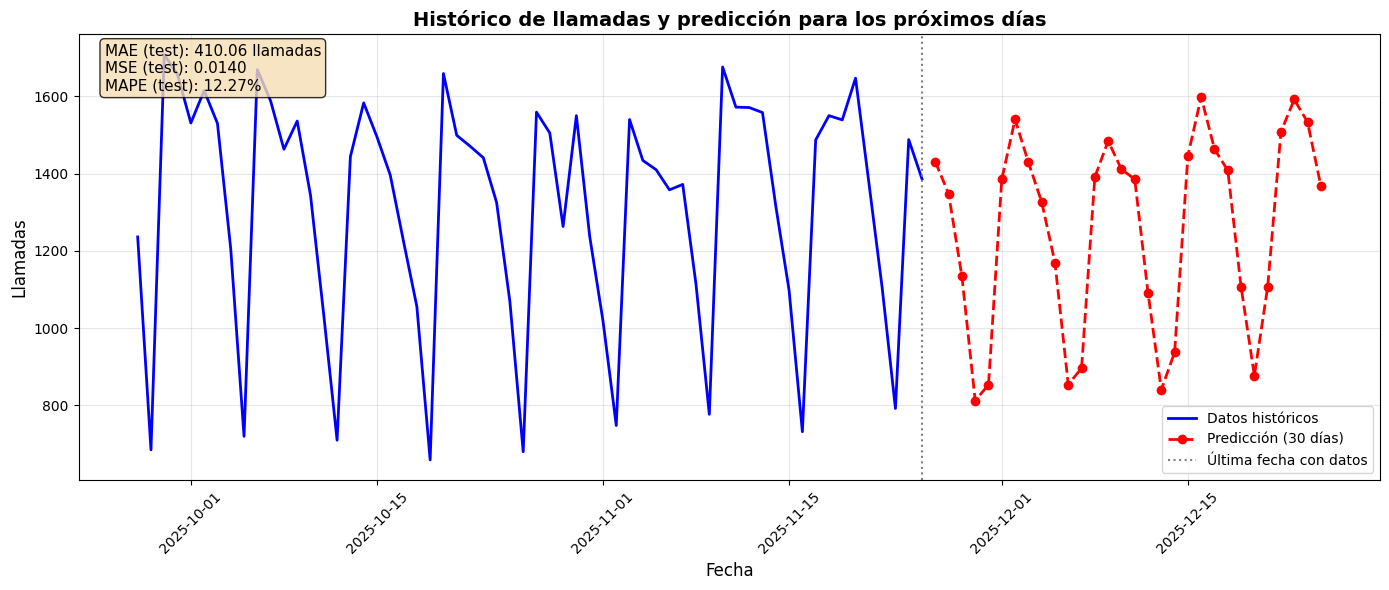

In [ ]:
import matplotlib.pyplot as plt

# Prcd "C:\Fabian\Portafolio\Pagina Web\Projects\forecasting and scheduling"
git init
git add .
git commit -m "Initial commit: LSTM and SARIMAX forecasting models"edicción para los próximos 15 días
last_window = data_array[-window_size:]
last_window = np.expand_dims(last_window, axis=0)

pred_norm = model.predict(last_window, verbose=0)[0]
pred_calls = scaler.inverse_transform(pred_norm.reshape(-1, 1)).flatten()

print("Predicción de llamadas para los próximos 15 días:")
for i, calls in enumerate(pred_calls, 1):
    print(f"  Día {i}: {calls:.0f} llamadas")

# Fechas forecast
last_date = df['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

# Datos históricos (últimos 60 días)
historical_days = 60
historical_dates = df['date'].iloc[-historical_days:]
historical_calls = df['calls'].iloc[-historical_days:]

# Métricas (MAE real ya calculada fuera: mae_real) - recalculo por seguridad
mae_array = np.array([[test_mae]])
mae_real = scaler.inverse_transform(mae_array)[0, 0]

# Predicciones test para MAPE
pred_test_norm = model.predict(X_test, verbose=0)            # (test_samples, horizon)
pred_test_calls = scaler.inverse_transform(pred_test_norm.reshape(-1, 1)).reshape(pred_test_norm.shape)
y_test_calls = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# MAPE robusto (evita división por 0)
denominator = np.clip(y_test_calls, 1e-6, None)
mape_test = np.mean(np.abs(y_test_calls - pred_test_calls) / denominator) * 100

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(historical_dates, historical_calls, label='Datos históricos', color='blue', linewidth=2)
ax.plot(forecast_dates, pred_calls, label=f'Predicción ({forecast_horizon} días)', color='red', linewidth=2, linestyle='--', marker='o')
ax.axvline(x=last_date, color='gray', linestyle=':', linewidth=1.5, label='Última fecha con datos')

textstr = f"MAE (test): {mae_real:.2f} llamadas\nMSE (test): {test_loss:.4f}\nMAPE (test): {mape_test:.2f}%"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=props)

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Llamadas', fontsize=12)
ax.set_title('Histórico de llamadas y predicción para los próximos días', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()